<a href="https://colab.research.google.com/github/PuttaUmadevi/BDA/blob/main/160122771016_BDA_assinment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



1. Build a Classification Model with Spark with a dataset of your choice


=== Dataset Summary ===
root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)


=== Quality Distribution ===
+-------+-----+
|quality|count|
+-------+-----+
|      3|   10|
|      4|   53|
|      5|  681|
|      6|  638|
|      7|  199|
|      8|   18|
+-------+-----+


=== Model Evaluation ===
Accuracy: 0.8763636363636363
F1 Score: 0.8646216797605687
AUROC: 0.862342459800087

Confusion Matrix:


,Actual/Predicted,0.0,1.0
0,1.0,24,15
1,0.0,226,10


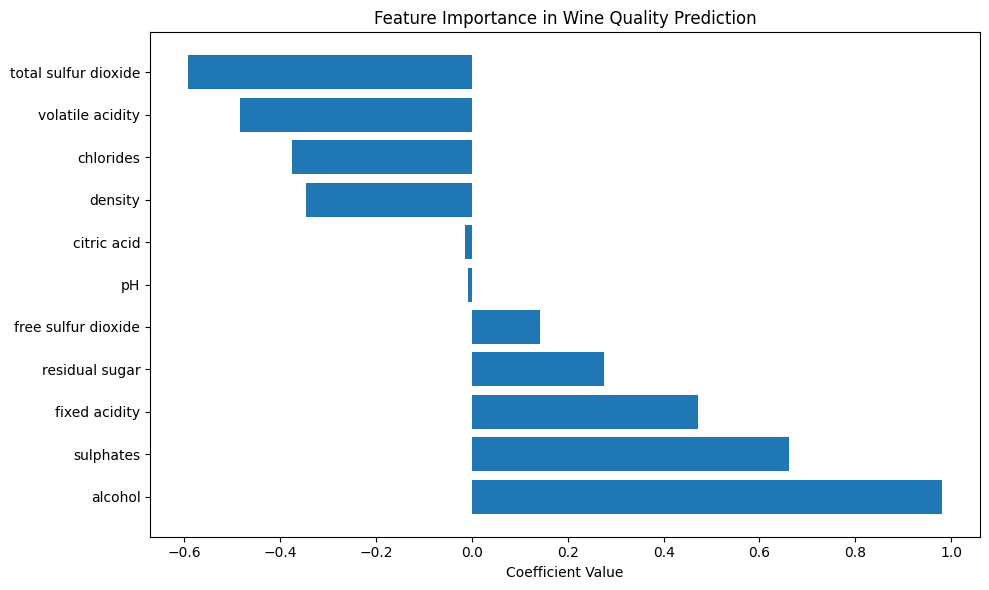


=== Sample Predictions ===
+-------+--------------+-----+----------+--------------------+
|quality|quality_binary|label|prediction|         probability|
+-------+--------------+-----+----------+--------------------+
|      7|             1|  1.0|       1.0|[0.21136031278836...|
|      6|             0|  0.0|       0.0|[0.86959847543333...|
|      5|             0|  0.0|       0.0|[0.98734427943255...|
|      5|             0|  0.0|       0.0|[0.99284079836783...|
|      7|             1|  1.0|       1.0|[0.36397587340294...|
+-------+--------------+-----+----------+--------------------+
only showing top 5 rows



In [ ]:
# Install Java and Spark (required for Google Colab)
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark

# Set environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

# Initialize Spark
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import pandas as pd

# Create Spark session
spark = SparkSession.builder \
    .appName("WineQualityColab") \
    .config("spark.executor.memory", "1g") \
    .config("spark.driver.memory", "1g") \
    .getOrCreate()

# Download the wine quality dataset
!wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv

# Load data with correct delimiter
wine_df = spark.read.csv("winequality-red.csv", header=True, inferSchema=True, sep=";")

# Data Exploration
print("=== Dataset Summary ===")
wine_df.printSchema()

print("\n=== Quality Distribution ===")
wine_df.groupBy("quality").count().orderBy("quality").show()

# Convert to binary classification (good/bad wine with threshold at 7)
wine_df = wine_df.withColumn("quality_binary", (col("quality") >= 7).cast("integer"))

# Feature Engineering
feature_cols = [c for c in wine_df.columns if c not in ["quality", "quality_binary"]]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="raw_features")

# Feature Scaling
scaler = StandardScaler(inputCol="raw_features",
                       outputCol="features",
                       withStd=True,
                       withMean=True)

# Label Indexing
label_indexer = StringIndexer(inputCol="quality_binary", outputCol="label")

# Model Definition
lr = LogisticRegression(featuresCol="features",
                      labelCol="label",
                      family="binomial",
                      maxIter=10)

# Pipeline
pipeline = Pipeline(stages=[assembler, scaler, label_indexer, lr])

# Train-Test Split
train_data, test_data = wine_df.randomSplit([0.8, 0.2], seed=42)

# Train Model
model = pipeline.fit(train_data)

# Make Predictions
predictions = model.transform(test_data)

# Evaluation
print("\n=== Model Evaluation ===")

# Multiclass Metrics
multi_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
print(f"Accuracy: {multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: 'accuracy'})}")
print(f"F1 Score: {multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: 'f1'})}")

# Binary Metrics
binary_evaluator = BinaryClassificationEvaluator(labelCol="label")
print(f"AUROC: {binary_evaluator.evaluate(predictions)}")

# Confusion Matrix
conf_matrix = predictions.crosstab("label", "prediction")
conf_matrix_pd = conf_matrix.toPandas()
conf_matrix_pd = conf_matrix_pd.rename(columns={"label_prediction": "Actual/Predicted"})
print("\nConfusion Matrix:")
display(conf_matrix_pd)

# Feature Importance Visualization
lr_model = model.stages[-1]
coefficients = lr_model.coefficients.toArray()
feature_importance = pd.DataFrame({
    "Feature": feature_cols,
    "Importance": coefficients
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance["Feature"], feature_importance["Importance"])
plt.title("Feature Importance in Wine Quality Prediction")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.show()

# Sample Predictions
print("\n=== Sample Predictions ===")
predictions.select("quality", "quality_binary", "label", "prediction", "probability").show(5)

# Stop Spark session
spark.stop()

2. Build a Clustering Model with Spark with a dataset of your choice

In [ ]:
# Step 1: Initialize Spark Session
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("SimpleWineClustering") \
    .getOrCreate()

# Step 2: Load Dataset
data_path = "winequality-red.csv"  # Make sure this file is available
wine_df = spark.read.csv(data_path, header=True, inferSchema=True, sep=';')

# Show basic info
print(f"Dataset loaded with {wine_df.count()} rows")
wine_df.printSchema()

# Step 3: Prepare Features
from pyspark.ml.feature import VectorAssembler

# Use all columns except quality as features
feature_cols = [col for col in wine_df.columns if col != 'quality']
print(f"\nUsing features: {feature_cols}")

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
feature_data = assembler.transform(wine_df)

# Step 4: Train K-Means Model
from pyspark.ml.clustering import KMeans

k = 3  # Number of clusters
print(f"\nTraining K-Means with k={k}...")

kmeans = KMeans(featuresCol="features",
               k=k,
               seed=42,
               predictionCol="cluster")
model = kmeans.fit(feature_data)

# Step 5: Get Predictions
clustered_data = model.transform(feature_data)

print("\nCluster assignments:")
clustered_data.select("features", "cluster").show(10, truncate=False)

# Step 6: Evaluate Clusters
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator(featuresCol="features",
                              predictionCol="cluster",
                              metricName="silhouette")
score = evaluator.evaluate(clustered_data)
print(f"\nClustering Evaluation:")
print(f"Silhouette Score: {score:.3f} (Higher is better)")

# Show cluster sizes
print("\nCluster distribution:")
clustered_data.groupBy("cluster").count().orderBy("cluster").show()

# Step 7: Cleanup
spark.stop()
print("\nSpark session closed.")

Dataset loaded with 1599 rows
root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)


Using features: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']

Training K-Means with k=3...

Cluster assignments:
+--------------------------------------------------------+-------+
|features                                                |cluster|
+--------------------------------------------------------+-------+
|[7

3. Build a Recommendation Engine with Spark with a dataset of your choice

In [ ]:
# Initialize Spark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("MovieRecommender").getOrCreate()

# Download and extract MovieLens dataset safely
import os
import shutil

dataset_path = "ml-latest-small"
zip_file = "ml-latest-small.zip"
url = "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"

# Clean up previous runs if they exist
if os.path.exists(dataset_path):
    shutil.rmtree(dataset_path)
if os.path.exists(zip_file):
    os.remove(zip_file)

# Download and extract
!wget -q {url}
!unzip -q {zip_file}

# Verify files exist before loading
if not os.path.exists(f"{dataset_path}/ratings.csv"):
    raise FileNotFoundError("Ratings file not downloaded properly")

# Load data
ratings = spark.read.csv(f"{dataset_path}/ratings.csv", header=True, inferSchema=True)
print("Ratings data sample:")
ratings.show(5)

movies = spark.read.csv(f"{dataset_path}/movies.csv", header=True, inferSchema=True)
print("\nMovies data sample:")
movies.show(5, truncate=False)

# Build and evaluate model (rest of your code remains the same)
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col

# Split data
(train, test) = ratings.randomSplit([0.8, 0.2], seed=42)

# Train ALS model
als = ALS(
    userCol="userId",
    itemCol="movieId",
    ratingCol="rating",
    coldStartStrategy="drop",
    nonnegative=True
)
model = als.fit(train)

# Evaluate
predictions = model.transform(test)
evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="rating",
    predictionCol="prediction"
)
rmse = evaluator.evaluate(predictions)
print(f"\nModel RMSE: {rmse:.3f}")



spark.stop()

Ratings data sample:
+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows


Movies data sample:
+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5  